# Surface code

In [1]:
import import_ipynb
import TQEC_tools
import numpy as np
import stimcirq
import networkx as nx
from cirq.contrib.svg import SVGCircuit
import sinter
from typing import List
import matplotlib.pyplot as plt

importing Jupyter notebook from TQEC_tools.ipynb


In [2]:
# Calculate relative position of data qubits and syndrome qubits
def physical_qubit_pos( distance ):
    Data_qubit_structure = np.ones((distance,distance))
    
    # Data qubits on each vertex on the grid
    Data_pos = { }
    Data_positions = Data_qubit_structure.nonzero()
    for data_num in np.arange(distance**2):
        Data_pos[data_num] = ( Data_positions[0][data_num], Data_positions[1][data_num])
    
    # padding zero and put syndromes on (d+1)*(d+1) grid
    ## padding list
    ## body
    body = np.ones((distance-1,distance-1))
    body = np.pad(body, [(1, 1),(1,1)])
    
    ## top X
    top = [1 if i % 2 == 0
            else 0 for i in range(distance-1)]
    top = np.pad(top, (1, 1))
    
    ## bottom X
    bottom = [1 if i % 2 == 1
            else 0 for i in range(distance-1)]
    bottom = np.pad(bottom, (1, 1))
    
    ## left Z
    left = [[1] if i % 2 == 1
            else [0] for i in range(distance-1)]
    left = np.pad(left, [(1, 1),(0,0)])
    
    ## right Z
    right = [[1] if i % 2 == 0
            else [0] for i in range(distance-1)]
    right = np.pad(right, [(1, 1),(0,0)])

    body[0,:] = top
    body[:,0] = left[:,0]
    body[:,-1] = right[:,0]
    body[-1,:] = bottom

    X_syn = { }
    Z_syn = { }
    Syn_positions = body.nonzero()
    
    for syn_num in np.arange(distance**2 - 1):
        x = Syn_positions[0][syn_num]
        y = Syn_positions[1][syn_num]
        
        # separate X syndrome and Z syndrome
        if (x+y)%2 == 0:
            X_syn[syn_num + distance**2] = ( x-0.5, y-0.5)
        else:
            Z_syn[syn_num + distance**2] = ( x-0.5, y-0.5)   

    return Data_pos, X_syn, Z_syn

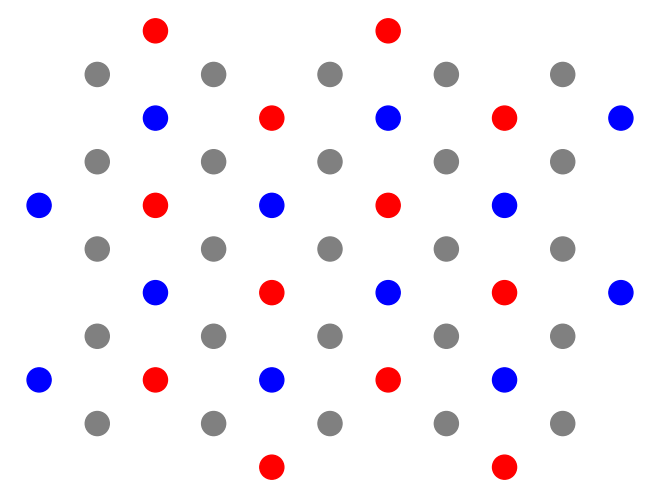

In [3]:
distance = 5
d,s_x,s_z = physical_qubit_pos( distance )

G = nx.Graph()
# Data qubits
for num,pos in d.items():
    G.add_node(num,pos=pos, color='grey')
# X syndrome qubits
for num,pos in s_x.items():
    G.add_node(num,pos=pos, color='red')
# Z syndrome qubits
for num,pos in s_z.items():
    G.add_node(num,pos=pos, color='blue')
    
pos=nx.get_node_attributes(G,'pos')
color = nx.get_node_attributes(G,'color').values()

nx.draw(G,pos=pos,node_color=color)

In [4]:
def Surface_code(distance,R,err):
    
    # Find pair qubits based on given active syndrome qubits and relative distance delta
    def pair_qubits( qubits, delta ):
        
        # check if there is a relative qubit in our structure
        def delta_qubit( pos, delta ):
            try:
                return [ pos2num[pos], pos2num[(pos[0]+delta[0],pos[1]+delta[1])] ]
            except:
                pass
            
        active_pos = [ num2pos[num] for num in qubits ]
        relative_qubits = np.array([ delta_qubit(pos,delta) for pos in active_pos 
                                    if delta_qubit(pos,delta) != None ])
        
        return relative_qubits[:,0], relative_qubits[:,1]

    Data_dict, Syn_X_dict, Syn_Z_dict = physical_qubit_pos( distance )
    Data = distance**2
    Syn = Data - 1

    # Physical qubit structures
    Structure = np.arange( Data + Syn )
    data_qubits = Structure[:Data]
    syn_qubits = Structure[Data:]

    num2pos = {**Data_dict, **Syn_X_dict, **Syn_Z_dict}
    pos2num = {v: k for k, v in num2pos.items()}

    # Create TQEC circuit
    Surface_circuit = TQEC_tools.TQEC()
    circuit = Surface_circuit.circuit

    # Initialize physical qubits
    Surface_circuit.physical_qubits(len(Structure))
    Surface_circuit.bitflip_err(Structure,err)

    ################################################################
    #########  Repeat syndrome extract circuit R rounds  ###########
    ################################################################

    SynX_list = list(Syn_X_dict.keys())
    SynZ_list = list(Syn_Z_dict.keys())

    for _ in np.arange(R):
        
        # Syndrome extract circuit for step 0
        # Hadamard operator on X syndrome qubits
        Surface_circuit.single_gate("H",SynX_list)
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)
        
        # Syndrome extract circuit for step 1
        S_X_1_c, S_X_1_t = pair_qubits( SynX_list, (-0.5,0.5) )
        S_Z_1_t, S_Z_1_c = pair_qubits( SynZ_list, (-0.5,0.5) )
        control_qubits = np.concatenate((S_X_1_c, S_Z_1_c))
        target_qubits = np.concatenate((S_X_1_t, S_Z_1_t))
        
        Surface_circuit.cnot(control_qubits,target_qubits)
        # Depolarizing error for each cnot gate
        Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)

        # Syndrome extract circuit for step 2
        S_X_2_c, S_X_2_t = pair_qubits( SynX_list, (0.5,0.5) )
        S_Z_2_t, S_Z_2_c = pair_qubits( SynZ_list, (-0.5,-0.5) )
        control_qubits = np.concatenate((S_X_2_c, S_Z_2_c))
        target_qubits = np.concatenate((S_X_2_t, S_Z_2_t))
        
        Surface_circuit.cnot(control_qubits,target_qubits)
        # Depolarizing error for each cnot gate
        Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)

        # Syndrome extract circuit for step 3
        S_X_3_c, S_X_3_t = pair_qubits( SynX_list, (-0.5,-0.5) )
        S_Z_3_t, S_Z_3_c = pair_qubits( SynZ_list, (0.5,0.5) )
        control_qubits = np.concatenate((S_X_3_c, S_Z_3_c))
        target_qubits = np.concatenate((S_X_3_t, S_Z_3_t))
        
        Surface_circuit.cnot(control_qubits,target_qubits)
        # Depolarizing error for each cnot gate
        Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)
        
        # Syndrome extract circuit for step 4
        S_X_4_c, S_X_4_t = pair_qubits( SynX_list, (0.5,-0.5) )
        S_Z_4_t, S_Z_4_c = pair_qubits( SynZ_list, (0.5,-0.5) )
        control_qubits = np.concatenate((S_X_4_c, S_Z_4_c))
        target_qubits = np.concatenate((S_X_4_t, S_Z_4_t))
        
        Surface_circuit.cnot(control_qubits,target_qubits)
        # Depolarizing error for each cnot gate
        Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)

        # Syndrome extract circuit for step 5
        # Hadamard operator on X syndrome qubits
        Surface_circuit.single_gate("H",SynX_list)
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)
        
        # Bit-flip errors before we measure syndrome qubits
        Surface_circuit.bitflip_err( SynX_list + SynZ_list, err )
        # Measure all syndrome qubits
        Surface_circuit.measure( syn_qubits )
        # Idling errors for deactivated qubits
        Surface_circuit.idling_err(err)

        # Initial state was |0>_L 
        # first round : we check only Z syndromes
        if _ == 0:
            Surface_circuit.detector( SynZ_list, measure_time = [ 0 ] )
        else:
            Surface_circuit.detector( SynX_list + SynZ_list )
    ################################################################
    ################################################################
    ################################################################

    # Measurement data qubits with bit-flip errors
    Surface_circuit.bitflip_err( data_qubits, err )
    Surface_circuit.measure( data_qubits, 'data' )

    # Measure in Z basis : get parity between data qubits and Z syndromes
    for syn in SynZ_list:
        syn_pos = num2pos[syn]
        relative_data = [ ]
        for delta in [(0.5,0.5),(-0.5,0.5),(0.5,-0.5),(-0.5,-0.5)]:
            try:
                relative_data.append( pos2num[(syn_pos[0]+delta[0],syn_pos[1]+delta[1])] )
            except:
                pass
            
        Surface_circuit.detector_final( [syn], [ q for q in relative_data if q !=None] , Data )

    # Observable
    Surface_circuit.observable( data_qubits[::distance] )
    
    return circuit


# Each idling, two qubit and single qubit gates, measurement error rate
err = 1e-4
# Number of rounds for syndrome extract circuit
R = 3
# Number of data qubits in Repetition code
distance = 3

circuit = Surface_code(distance,R,err)
circuit

stim.Circuit('''
    QUBIT_COORDS 0
    QUBIT_COORDS 1
    QUBIT_COORDS 2
    QUBIT_COORDS 3
    QUBIT_COORDS 4
    QUBIT_COORDS 5
    QUBIT_COORDS 6
    QUBIT_COORDS 7
    QUBIT_COORDS 8
    QUBIT_COORDS 9
    QUBIT_COORDS 10
    QUBIT_COORDS 11
    QUBIT_COORDS 12
    QUBIT_COORDS 13
    QUBIT_COORDS 14
    QUBIT_COORDS 15
    QUBIT_COORDS 16
    X_ERROR(0.0001) 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    H 10 12 13 15
    DEPOLARIZE1(0.0001) 0 1 2 3 4 5 6 7 8 9 11 14 16
    CX 10 1 13 3 15 5 2 11 4 14 8 16
    DEPOLARIZE2(0.0001) 10 1 13 3 15 5 2 11 4 14 8 16
    DEPOLARIZE1(0.0001) 0 6 7 9 12
    CX 10 4 13 6 15 8 1 11 3 14 7 16
    DEPOLARIZE2(0.0001) 10 4 13 6 15 8 1 11 3 14 7 16
    DEPOLARIZE1(0.0001) 0 2 5 9 12
    CX 10 0 12 2 15 4 1 9 5 11 7 14
    DEPOLARIZE2(0.0001) 10 0 12 2 15 4 1 9 5 11 7 14
    DEPOLARIZE1(0.0001) 3 6 8 13 16
    CX 10 3 12 5 15 7 0 9 4 11 6 14
    DEPOLARIZE2(0.0001) 10 3 12 5 15 7 0 9 4 11 6 14
    DEPOLARIZE1(0.0001) 1 2 8 13 16
    H 10 12 13 15
 

In [5]:
sampler = circuit.compile_detector_sampler().sample(shots=1, append_observables=True)
print(sampler)

[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False]]


In [6]:
cirq_circuit = stimcirq.stim_circuit_to_cirq_circuit(circuit)
SVGCircuit(cirq_circuit)

In [7]:
distance, R, err = 5, 5, 0.01
circuit = Surface_code(distance,R,err)
num_shots = 10_000
num_logical_errors = TQEC_tools.count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 1980 wrong predictions (logical errors) out of 10000 shots


In [11]:
tasks = [
    sinter.Task(
        circuit=Surface_code(d,d*3,noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in np.linspace(1e-5,1e-2,num=15)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=2000,
)

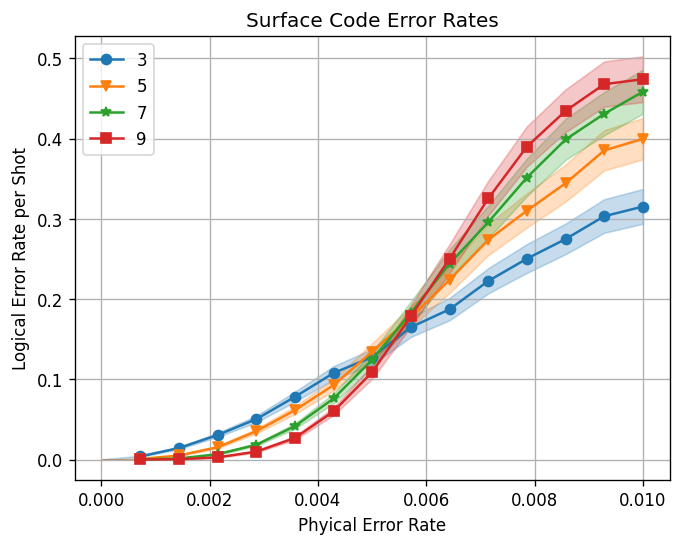

In [12]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)

ax.set_title("Surface Code Error Rates")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)